In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from tqdm.notebook import trange
from nltk.stem import WordNetLemmatizer

In [2]:
dt_movie = pd.read_csv("ml-latest/movies.csv")
dt_ratings = pd.read_csv("ml-latest/ratings.csv")
dt = pd.merge(dt_ratings, dt_movie)[["userId", "movieId", "title", "genres", "rating"]]

(0.0, 100.0)

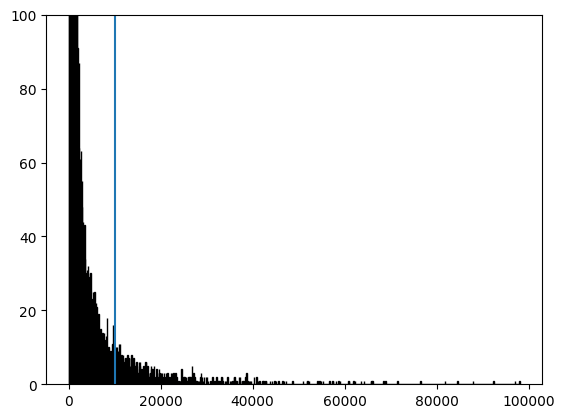

In [3]:
plt.hist(dt.groupby(['movieId']).userId.count() , color = 'blue', bins=1000, edgecolor = 'black')
plt.plot([10000 for i in range(1024)], [i for i in range(1024)])
plt.ylim([0, 100])

In [4]:
threshold = 8000
movieId = np.array(sorted(dt.movieId.unique()))[(dt.groupby(['movieId']).userId.count() > threshold).to_numpy()]

movieId = set(movieId)
right_ind = np.ones((len(dt)))
for i in trange(len(dt)):
    if dt.movieId.to_numpy()[i] not in movieId:
        right_ind[i] = -1
indexes = right_ind > 0


dt.iloc[indexes]

  0%|          | 0/27753444 [00:00<?, ?it/s]

,userId,movieId,title,genres,rating
32902,1,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,2.5
32903,4,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,3.5
32904,26,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,4.0
32905,56,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,4.0
32906,67,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,1.0
...,...,...,...,...,...
24976553,283101,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,2.5
24976554,283116,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,4.0
24976555,283153,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,4.0
24976556,283187,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,3.5


In [5]:
dt = dt.iloc[indexes]

In [6]:
(dt.groupby(["userId"]).rating.count() < 3).sum()

17559

In [7]:
user_count = len(dt.groupby(["userId"]))
index = np.arange(1, user_count + 1)
user_for_skip = index[(dt.groupby(["userId"]).rating.count() < 3).values]
user_for_skip = set(user_for_skip)
right_ind = np.ones((len(dt)))
for i in trange(len(dt)):
    if dt.userId.to_numpy()[i] in user_for_skip:
        right_ind[i] = -1
indexes = right_ind > 0


dt.iloc[indexes]

  0%|          | 0/16153870 [00:00<?, ?it/s]

,userId,movieId,title,genres,rating
32902,1,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,2.5
32903,4,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,3.5
32904,26,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,4.0
32905,56,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,4.0
32906,67,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,1.0
...,...,...,...,...,...
24976553,283101,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,2.5
24976554,283116,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,4.0
24976555,283153,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,4.0
24976556,283187,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,3.5


In [8]:
dt = dt.iloc[indexes]

In [9]:
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    punctuation_marks = ",.?!:;\'\(\)\{\}\|"
    stop_words = ["a", "the"]
    text = text.lower()
    for symbol in text:
        if symbol in punctuation_marks:
            text = text.replace(symbol, " ")
    if text == " no genres listed ":
        return [text[1:-1]]
    text = text.replace("\n", "")
    if text[-1] == " ":
        text = text[:-1]
    tokens = []
    for token in text.split(" "):
        if token != "" and token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return tokens

In [10]:
def show_graph(vocab, sizes):
    show_ = 20
    fig, ax = plt.subplots(3, 1, figsize=(15, 9))

    plt.subplot(312)
    vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1])}
    plt.title('least popular words')
    plt.bar(list(vocab.keys())[:show_], list(vocab.values())[:show_])

    plt.subplot(311)
    vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1], reverse=True)}
    plt.title('most popular words')
    plt.bar(list(vocab.keys())[:show_], list(vocab.values())[:show_])

    plt.subplot(313)
    plt.title('sequence sizes')
    plt.bar(list(sizes.keys()), list(sizes.values()))

    fig.tight_layout()
    plt.show()

In [11]:
def update_vocab(dt_merge, vocab, sizes, max_len, genres=False, print_long_tokens=False):
    for_skip = []
    dt = dt_merge.genres if genres else dt_merge.title
    for i in trange(len(dt)):
        title = dt.to_numpy()[i]
        title_vocab = Counter(tokenize(title))
        if(len(title_vocab)) > max_len:
            if print_long_tokens:
                print(dt_merge.title.to_numpy()[i])
            for_skip.append(dt_merge.movieId.to_numpy()[i])
            continue
        sizes[len(title_vocab)] += 1
        vocab.update(title_vocab)
    return for_skip

In [12]:
vocab_title = Counter()
sizes_title = Counter()

vocab_genres = Counter()
sizes_genres = Counter()
movie_for_skip = []
movie_for_skip.extend(update_vocab(dt, vocab_title, sizes_title, 11, False))
movie_for_skip.extend(update_vocab(dt, vocab_genres, sizes_genres, 8, True))

  0%|          | 0/15153408 [00:00<?, ?it/s]

  0%|          | 0/15153408 [00:00<?, ?it/s]

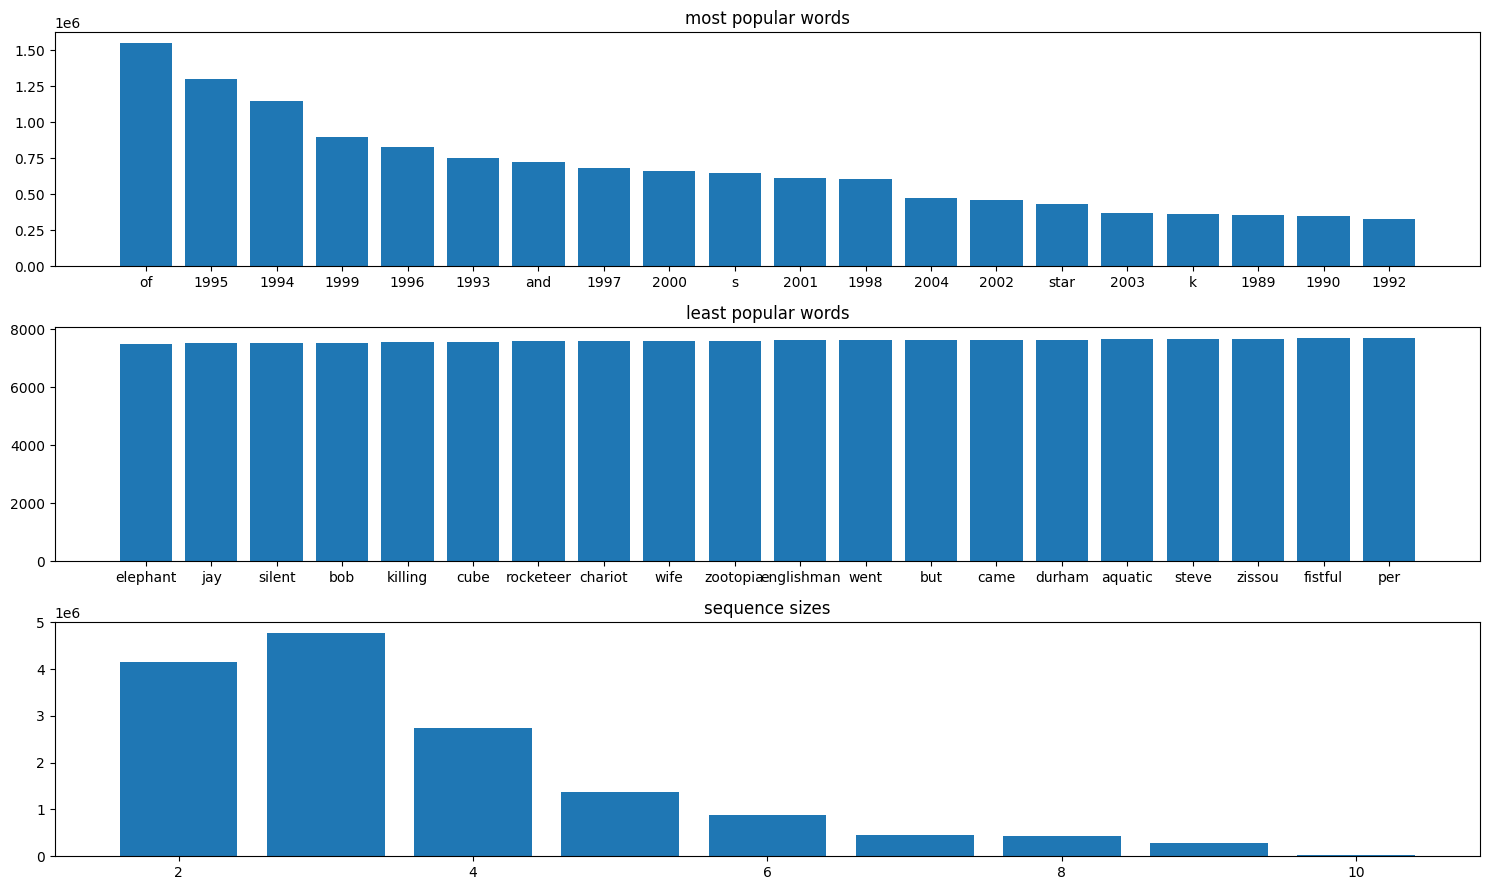

In [13]:
show_graph(vocab_title, sizes_title)

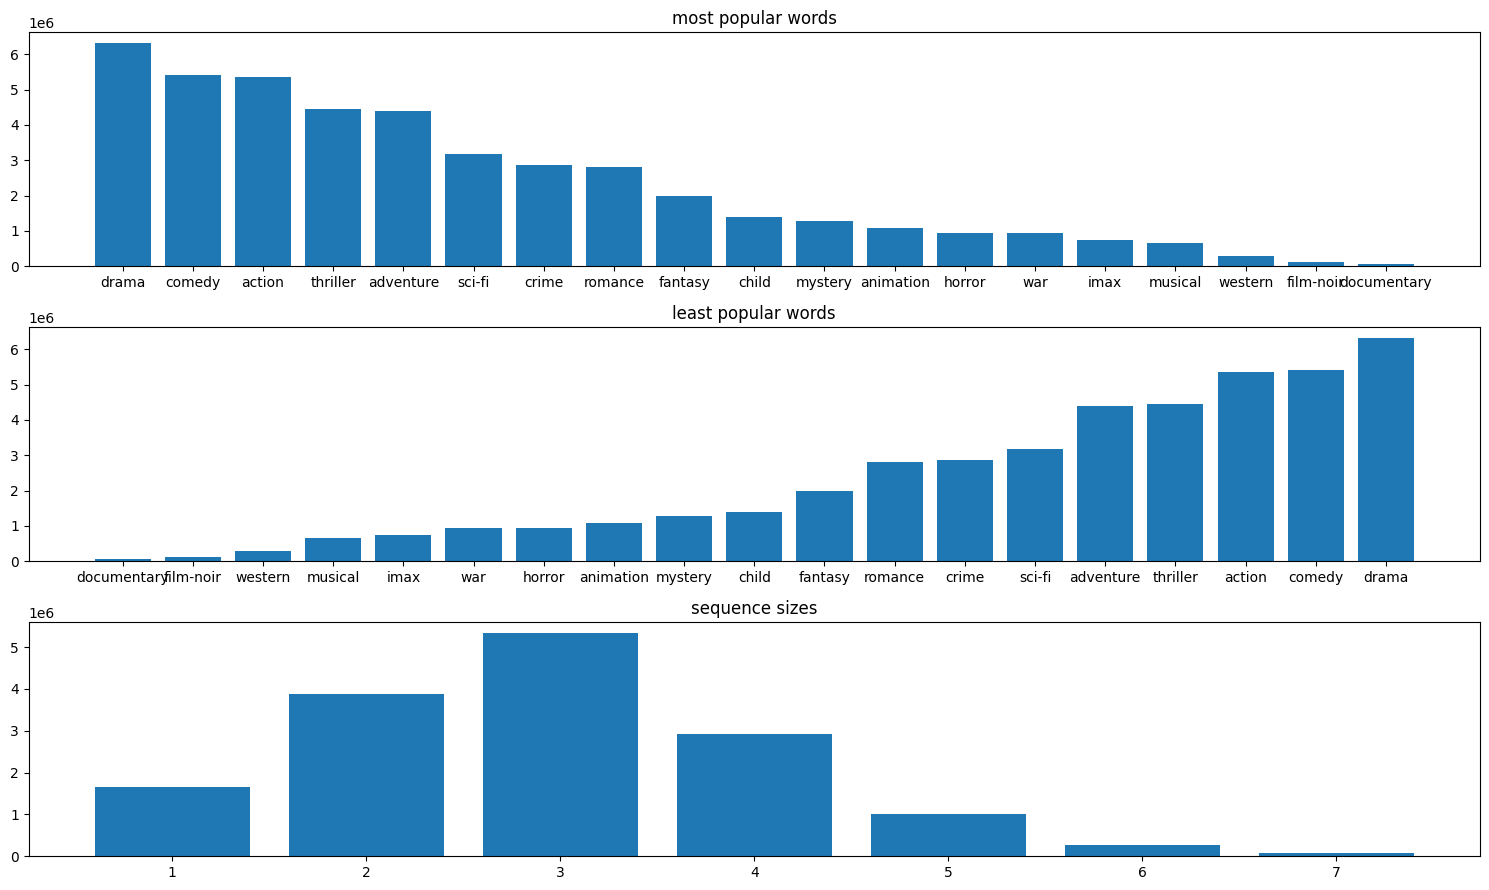

In [14]:
show_graph(vocab_genres, sizes_genres)

In [16]:
vocab_title = Counter()
sizes_title = Counter()

vocab_genres = Counter()
sizes_genres = Counter()
movie_for_skip = []
movie_for_skip.extend(update_vocab(dt, vocab_title, sizes_title, 10, False))
movie_for_skip.extend(update_vocab(dt, vocab_genres, sizes_genres, 7, True))

  0%|          | 0/15153408 [00:00<?, ?it/s]

  0%|          | 0/15153408 [00:00<?, ?it/s]

In [17]:
tok_to_ind = {
    "[PAD]": 0,
    "[UNK]": 1,
    "no genres listed": 2
}
ind_to_tok = {
    0: "[PAD]",
    1: "[UNK]",
    2: "no genres listed"
}

In [18]:
min_frequency = 3
last_free_index = len(tok_to_ind)
for token in vocab_title.keys():
    if vocab_title[token] >= min_frequency and token not in tok_to_ind:
        tok_to_ind[token] = last_free_index
        ind_to_tok[last_free_index] = token
        last_free_index += 1

for token in vocab_genres.keys():
    if vocab_genres[token] >= min_frequency and token not in tok_to_ind:
        tok_to_ind[token] = last_free_index
        ind_to_tok[last_free_index] = token
        last_free_index += 1

In [21]:
movie_for_skip = set(movie_for_skip)
right_ind = np.ones((len(dt)))
for i in trange(len(dt)):
    if dt.movieId.to_numpy()[i] in movie_for_skip:
        right_ind[i] = -1
indexes = right_ind > 0
dt.iloc[indexes]

  0%|          | 0/15153408 [00:00<?, ?it/s]

,userId,movieId,title,genres,rating
32902,1,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,2.5
32903,4,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,3.5
32904,26,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,4.0
32905,56,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,4.0
32906,67,1590,Event Horizon (1997),Horror|Sci-Fi|Thriller,1.0
...,...,...,...,...,...
24976553,283101,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,2.5
24976554,283116,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,4.0
24976555,283153,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,4.0
24976556,283187,2366,King Kong (1933),Action|Adventure|Fantasy|Horror,3.5


In [22]:
dt = dt.iloc[indexes]

In [23]:
dt.to_csv("data.csv")

In [19]:
import pickle 

with open('tok_to_ind.pkl', 'wb') as f:
    pickle.dump(tok_to_ind, f)